## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
from scipy import stats

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KDTree

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def euclidean(self, X_train, X_test):
        X_train = X_train[:,:, np.newaxis]
        dist = (X_train - X_test.T) ** 2
        dist = np.sqrt(np.sum(dist, axis=1))
        return dist
    
    def brute(self, X):
        distances = self.euclidean(self.X_train, X)
        distances = distances.argpartition(self.K, axis=0)[:self.K, :]
        values = np.take(self.y_train, distances.T)
        return stats.mode(values, axis=1)[0].reshape(-1)
            
    def kd_tree(self, X):
        nearest_x_ind = self.tree.query(X, k=self.K, return_distance=False)
        values = np.take(self.y_train, nearest_x_ind)
        return stats.mode(values, axis=1)[0].reshape(-1)
    
    def __init__(
        self, 
        n_neighbors, 
        algorithm='brute', 
        leaf_size = 40,  
    ):
        self.K = n_neighbors
        self.algorithm_name = algorithm
        
        if algorithm == 'brute':
            self.algorithm = self.brute
                
        elif algorithm == 'kd_tree':
            self.algorithm = self.kd_tree
            self.leaf_size = leaf_size
                
        else:
            assert 0, 'Wrong algorithm\'s name'
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        if self.algorithm_name == 'kd_tree':
            self.tree = KDTree(X, leaf_size=self.leaf_size)
    
    def predict(self, X):
        return self.algorithm(X)
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 996 µs, sys: 92 µs, total: 1.09 ms
Wall time: 1.17 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 440 µs, total: 440 µs
Wall time: 523 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 3.3 ms, sys: 0 ns, total: 3.3 ms
Wall time: 9.46 ms


array([1, 1, 1, 1, 2, 2, 0, 2, 0, 1, 1, 0, 0, 2, 0])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 3.97 ms, sys: 0 ns, total: 3.97 ms
Wall time: 4.36 ms


array([1, 1, 1, 1, 2, 2, 0, 2, 0, 1, 1, 0, 0, 2, 0])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 1.61 ms, sys: 157 µs, total: 1.77 ms
Wall time: 4.7 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 801 µs, sys: 26 µs, total: 827 µs
Wall time: 905 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 3.41 ms, sys: 335 µs, total: 3.75 ms
Wall time: 6.37 ms


array([1, 1, 1, 1, 0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 2])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 0 ns, sys: 2.41 ms, total: 2.41 ms
Wall time: 3.91 ms


array([1, 1, 1, 1, 0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 2])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
train_size = 500
data = newsgroups['data'][:train_size]
target = newsgroups['target'][:train_size]

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
vectorizer = CountVectorizer(max_df=4, min_df=2)
X_train = vectorizer.fit_transform(data).toarray()
y_train = np.asarray(target)

In [22]:
old_dim = X_train.shape[1]

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
folds = 3
split_X = np.array_split(X_train, folds)
split_y = np.array_split(y_train, folds)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [24]:
def optimal(split_X, split_y, folds):
    scores = np.zeros(10)
    for k in range(10):
        my_clf = MyKNeighborsClassifier(n_neighbors=k+1, algorithm='kd_tree')
        score = 0
        for i in range(folds):
            X_train = np.concatenate([split_X[j] for j in range(folds) if j != i])
            y_train = np.concatenate([split_y[j] for j in range(folds) if j != i])
            X_test = split_X[i]
            y_test = split_y[i]
            my_clf.fit(X_train, y_train)
            my_clf_pred = my_clf.predict(X_test)
            score += accuracy_score(y_test, my_clf_pred)
        scores[k] = score / folds
    return scores
         

Метрика евклидова, векторизация с помощью CountVectorizer:

0.11391674482360581


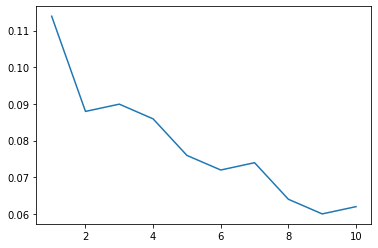

In [25]:
accuracy = optimal(split_X, split_y, folds)

plt.plot(range(1,11,1), accuracy)
print(accuracy.max())

Метрика косинусная, векторизация с помощью CountVectorizer:

0.07195248058100666


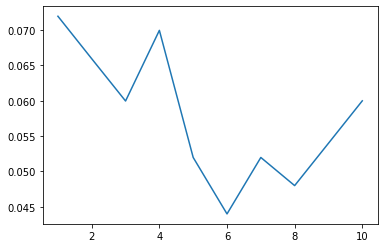

In [26]:
X_train = X_train / (np.sqrt((X_train ** 2).sum(axis=1))[:, np.newaxis] + 0.00001)

split_X = np.array_split(X_train, folds)

accuracy_cos = optimal(split_X, split_y, folds)
plt.plot(range(1,11,1), accuracy_cos)
print(accuracy_cos.max())

Метрика евклидова, векторизация с помощью TfidfVectorizer:

0.07396051270952071


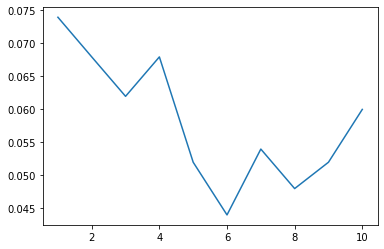

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_df=4, min_df=2)
X_train = tfidf_vectorizer.fit_transform(data).toarray()
split_X = np.array_split(X_train, folds)

accuracy_tfidf = optimal(split_X, split_y, folds)
plt.plot(range(1,11,1), accuracy_tfidf)
print(accuracy_tfidf.max())

Метрика косинусная, векторизация с помощью TfidfVectorizer:

0.07396051270952071


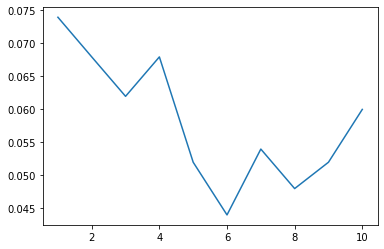

In [28]:
X_train = X_train / (np.sqrt((X_train ** 2).sum(axis=1))[:, np.newaxis] + 0.00001)

split_X = np.array_split(X_train, folds)

accuracy_tfidf_cos = optimal(split_X, split_y, folds)
plt.plot(range(1,11,1), accuracy_tfidf_cos)
print(accuracy_tfidf_cos.max())

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

ОТВЕТ: Лучше всего работает векторизация с CountVectorizer, метрика евклидова, сосед 1 (точность 0.11).

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [29]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [30]:
test_size = 500
data_test = newsgroups['data'][:test_size]
target_test = newsgroups['target'][:test_size]
data_all = data + data_test
target_all = np.concatenate((target, target_test))

X = vectorizer.fit_transform(data_all).toarray()
X_test = X[train_size:train_size+test_size, :]
y_test = np.asarray(target_test)
X_train = X[:train_size, :]
y_train = target[:train_size]

my_clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')
my_clf.fit(X_train, y_train)
my_clf_pred = my_clf.predict(X_test)
accuracy_score(y_test, my_clf_pred)

0.088

In [31]:
clf = KNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
accuracy_score(y_test, clf_pred)

0.09

И без того плохое качество стало ещё хуже. Вообще, при больших размерностях, чем больше размерности векторов, тем хуже работает knn из-за "проклятия размерности". Для тестовой выборки мы увеличивали словарь с обучающей выборки словами из тестовой, следовательно, и размерности векторов увеличились, поэтому качество немного упало.

In [32]:
print("Размерность векторов при тесте:", X.shape[1])
print("Размерность векторов при обучении:", old_dim)

Размерность векторов при тесте: 4608
Размерность векторов при обучении: 3269
